# Interact with fission product yields in ENDF-6 format (MF=8, MT=454/459)

In [13]:
import filecmp
import yaml

import matplotlib.pyplot as plt
import pandas as pd

import sandy

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import seaborn as sns
sns.set_style("whitegrid")

pd.options.display.float_format = '{:.5e}'.format

%matplotlib inline

In [2]:
file = "JEFF311NFY.txt"
tape = sandy.Endf6.from_file(file)
tape.to_series().head(10)

MAT   MF  MT 
3486  1   451     9.023200+4 2.300450+2         -1          1  ...
      8   454     9.023200+4 2.300450+2          2          0  ...
          459     9.023200+4 2.300450+2          2          0  ...
3540  1   451     9.223300+4 2.310380+2         -1          1  ...
      8   454     9.223300+4 2.310380+2          3          0  ...
          459     9.223300+4 2.310380+2          3          0  ...
3541  1   451     9.223400+4 2.320300+2         -1          1  ...
      8   454     9.223400+4 2.320300+2          1          0  ...
          459     9.223400+4 2.320300+2          1          0  ...
3542  1   451     9.223500+4 2.330250+2         -1          1  ...
Name: JEFF311NFY.txt, dtype: object

In [3]:
mat = tape.mat[0]
mf = 8
mt = 454

section = tape.read_section(mat, mf, mt)

In [4]:
print("\n".join(yaml.dump(section).splitlines()[:11]))

AWR: 230.045
E:
  400000.0:
    INTERP: 1
    ZAP:
      10010:
        DFY: 5.5423e-06
        FY: 1.6073e-05
      10020:
        DFY: 1.6564e-06
        FY: 4.9121e-06


In [5]:
fy = sandy.Fy.from_endf6(tape)

In [6]:
A = fy.energy_table(459, zam=922350)

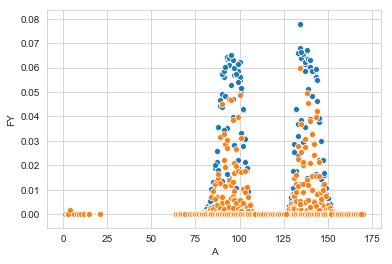

In [28]:
cfy=fy.filter_by("ZAM", 922350).filter_by("MT", 459).filter_by("E", 2.53e-2).expand_zap()
ify=fy.filter_by("ZAM", 922350).filter_by("MT", 454).filter_by("E", 2.53e-2).expand_zap()
fig,ax = plt.subplots()
ax = sns.scatterplot(x="A", y="FY", data=cfy, ax=ax)
ax = sns.scatterplot(x="A", y="FY", data=ify, ax=ax)

In [46]:
cfy[cfy.A.isin([88,89,90])].sort_values(by="FY", ascending=False).head(20)

,MAT,MT,ZAM,ZAP,E,FY,Z,A,M
292,3542,459,922350,390900,2.53000e-02,5.72900e-02,39,90,0
273,3542,459,922350,380900,2.53000e-02,5.72900e-02,38,90,0
318,3542,459,922350,400900,2.53000e-02,5.72900e-02,40,90,0
229,3542,459,922350,360900,2.53000e-02,4.89950e-02,36,90,0
290,3542,459,922350,390890,2.53000e-02,4.68960e-02,39,89,0
272,3542,459,922350,380890,2.53000e-02,4.68960e-02,38,89,0
249,3542,459,922350,370890,2.53000e-02,4.68740e-02,37,89,0
228,3542,459,922350,360890,2.53000e-02,4.43180e-02,36,89,0
250,3542,459,922350,370900,2.53000e-02,4.37470e-02,37,90,0
271,3542,459,922350,380880,2.53000e-02,3.56890e-02,38,88,0


In [47]:
ify[ify.A.isin([88,89,90])].sort_values(by="FY", ascending=False).head(20)

,MAT,MT,ZAM,ZAP,E,FY,Z,A,M
229,3542,454,922350,360900,2.53000e-02,4.50230e-02,36,90,0
228,3542,454,922350,360890,2.53000e-02,3.14570e-02,36,89,0
227,3542,454,922350,360880,2.53000e-02,1.65120e-02,36,88,0
206,3542,454,922350,350880,2.53000e-02,1.47500e-02,35,88,0
207,3542,454,922350,350890,2.53000e-02,1.29440e-02,35,89,0
251,3542,454,922350,370901,2.53000e-02,7.17440e-03,37,90,1
208,3542,454,922350,350900,2.53000e-02,4.76090e-03,35,90,0
186,3542,454,922350,340880,2.53000e-02,3.39290e-03,34,88,0
249,3542,454,922350,370890,2.53000e-02,2.55650e-03,37,89,0
250,3542,454,922350,370900,2.53000e-02,8.07800e-04,37,90,0
